In [1]:
import numpy as np
import matplotlib.pyplot as plt
plt.style.use('science')
import matplotlib
matplotlib.rcParams['font.size'] = 8
from phoebe.dependencies import distl
import phoebe
from astropy import units as u
from astropy import constants as c
phoebe.interactive_checks_off()
phoebe.interactive_constraints_off()

In [2]:
#values from the ELLC solution and derived quantities
ellc_res = {
    'period@binary': phoebe.gaussian(51.41888, 0.00008),
    't0_supconj': phoebe.gaussian(2458696.0199, 0.0002),
    'requivsumfrac': phoebe.gaussian(0.0705, 0.00045),
    'requivratio': phoebe.gaussian(0.47, 0.01),
    'incl@binary': phoebe.gaussian(86.35, 0.04),
    'sbratio': phoebe.gaussian(1.03,0.035),
    'ecc': phoebe.gaussian(0.4242, 0.0003),
    'per0': phoebe.gaussian(0.3718*180/np.pi,0.0023*180/np.pi),
    'sma@primary': phoebe.gaussian(44.564,0.1055),
    'ld_coeffs[0]@primary': phoebe.gaussian(0.2,0.1),
    'ld_coeffs[1]@primary': phoebe.gaussian(0.5,0.3),
    'ld_coeffs[0]@secondary': phoebe.gaussian(0.2,0.15),
    'ld_coeffs[1]@secondary': phoebe.gaussian(0.5,0.3),
    'vsini@primary': phoebe.gaussian(27.6,0.45),
    'vgamma_1': phoebe.gaussian(-11.68,0.03),
    'vgamma': phoebe.gaussian(-13.5,0.1),
    'semi_amplitude': phoebe.gaussian(47.74,0.06),
    'mass_function': phoebe.gaussian(0.438,0.002),
    'mass@primary': phoebe.gaussian(3.45,0.12),
    'requiv@primary': phoebe.gaussian(5.14,0.135),
    'teff@primary': phoebe.gaussian(9975,125),
    'logg@primary': phoebe.gaussian(3.63,0.20),
    'parallax': phoebe.gaussian(12.18,0.31),
    'logL@system': phoebe.gaussian(2.385,0.025),
    'r1': phoebe.gaussian(0.0479,0.00025),
    'r2': phoebe.gaussian(0.0226,0.0005),
    'teffratio': phoebe.gaussian(1.02,0.05),
    'syncpar@primary': phoebe.gaussian(5.45,0.50),
    'syncpar@secondary': phoebe.gaussian(50,10),
    'q@binary': phoebe.gaussian(0.588,0.018),
    'esinw': phoebe.gaussian(0.1541, 0.0009),
    'ecosw': phoebe.gaussian(0.3952, 0.0005)

}

All available data:

In [3]:
lc_tess_old = np.loadtxt('data/tess_corrected_old.txt') # detrending with periastron brightening
lc_tess = np.loadtxt('../data/photometry/tess_corrected.txt') # flat out-of-eclipse detrending
rv1_song = np.loadtxt('../data/RV/SONG.txt')
rv1_bischoff = np.loadtxt('../data/RV/bischoff_rv_fixed_time.txt')
# adjust all times to BJD
lc_tess[:,0] = lc_tess[:,0]+2457000 
lc_tess_old[:,0] = lc_tess_old[:,0]+2457000
rv1_song[:,0]=rv1_song[:,0]+2400000
rv1_bischoff[:,0]=rv1_bischoff[:,0]+2457000

Setup the PHOEBE bundle and all relevant parameters to compute a forward model with the ELLC backend and spherical geometry, to make sure that we still get a similar result as using pure ELLC (not interfacing with PHOEBE):

In [4]:
b = phoebe.default_binary()
b.add_dataset('lc', times=lc_tess[:,0], fluxes=lc_tess[:,1], sigmas=lc_tess[:,2], passband='TESS:T')
b.add_dataset('lc', times=lc_tess_old[:,0], fluxes=lc_tess_old[:,1], sigmas=lc_tess_old[:,2], passband='TESS:T')
b.add_dataset('rv', component='primary', times=rv1_song[:,0], rvs=rv1_song[:,1], sigmas=rv1_song[:,2])
b.add_dataset('rv', component='primary', times=rv1_bischoff[:,0], rvs=rv1_bischoff[:,1], sigmas=rv1_bischoff[:,2])

<ParameterSet: 47 parameters | contexts: constraint, dataset, figure, compute>

In [5]:
b.add_compute('ellc')
b.set_value_all('ld_mode', value='manual')
b.set_value_all('ld_func', value='square_root')
b.set_value_all('rv_method', compute='ellc01', value='flux-weighted')
# b.set_value_all('irrad_method', compute='ellc01', value='none')

In [6]:
b.add_constraint('requivsumfrac')
b.add_constraint('requivratio')
b.add_constraint('teffratio')

b.flip_constraint('requivsumfrac', solve_for='requiv@primary')
b.flip_constraint('requivratio', solve_for='requiv@secondary')
b.flip_constraint('teffratio', solve_for='teff@secondary')

b.flip_constraint('esinw', solve_for='ecc')
b.flip_constraint('ecosw', solve_for='per0')

<ConstraintParameter: {per0@binary@component} = arctan2({esinw@binary@component}, {ecosw@binary@component}) (solar units) => 0.0 deg>

In [7]:
b.flip_constraint('sma@primary', solve_for='sma@binary')

<ConstraintParameter: {sma@binary@component} = {sma@primary@component} * ((1.000000 / {q@binary@component}) + 1.000000) (solar units) => 5.3 solRad>

In [8]:
b.set_value_all('gravb_bol', 1.0)
b.set_value_all('irrad_frac_refl_bol', 1.0)
b.set_value_all('pblum_mode', 'dataset-scaled')

Set all relevant values in the bundle:

In [9]:
ph_params = ['t0_supconj', 'period@binary', 'requivsumfrac', 'requivratio', 
             'incl@binary', 'esinw', 'ecosw', 'teff@primary', 'teffratio', 'q@binary',
             'sma@primary', 'vgamma', 'syncpar@primary', 'syncpar@secondary']
for twig in ph_params:
    b.set_value(twig, ellc_res[twig].loc)
    
b.set_value_all('ld_coeffs@primary', [0.2,0.5])
b.set_value_all('ld_coeffs@secondary', [0.2,0.5])

Compute with 'sphere' and 'roche' distortions:

In [10]:
b.set_value_all('distortion_method', compute='ellc01', value='sphere')
b.set_value_all('irrad_method', compute='ellc01', value='none') # this needed because of ellc irrad issue
b.run_checks()
b.run_delayed_constraints()
b.run_compute('ellc01', model='sphere')

b.set_value_all('distortion_method', compute='ellc01', value='roche')
b.set_value_all('irrad_method', compute='ellc01', value='lambert') # this needed because of ellc irrad issue
b.run_checks()
b.run_delayed_constraints()
b.run_compute('ellc01', model='roche')

100%|██████████| 4/4 [00:10<00:00,  2.59s/it]


<ParameterSet: 11 parameters | kinds: rv, lc>

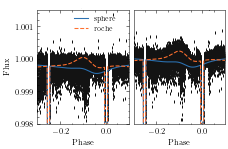

In [12]:
fig, axes = plt.subplots(1,2, figsize=[3.36, 2.0941842916664606])
fig.set_rasterized(True)
b.plot(kind='lc', dataset='lc01', model=['sphere', 'roche'], x='phases', y='fluxes', 
           s={'dataset': 0.0025, 'model': 0.025}, ylim=((0.998,1.001)),
           marker={'dataset': '.'}, ax=axes[0], draw=True)
b.plot(kind='lc', dataset='lc02', model=['sphere', 'roche'], x='phases', y='fluxes', 
           s={'dataset': 0.0025, 'model': 0.025}, ylim=((0.998,1.001)),
           marker={'dataset': '.'}, ax=axes[1], draw=True)

axes[0].set(xlim=[-0.3, 0.1], ylim=[0.998,1.0015], ylabel='Flux', xlabel='Phase')
axes[0].legend(bbox_to_anchor=(0.25,0.95), loc="upper left", bbox_transform=fig.transFigure, fontsize=7, labels=['', 'sphere', 'roche'])
axes[1].set(xlim=[-0.3, 0.1], ylim=[0.998,1.0015], yticks=[], xlabel='Phase', ylabel='')
plt.subplots_adjust(hspace=0.05, wspace=0.05)
fig.savefig('plots/' + 'periastron.pdf', dpi=300)
plt.show()